
## Assessing Climate Change Impacts on a Pair of Symbiotic Species with Ensemble Species Distribution Models: *Xantusia vigilis*

*How can models of climate change effects on geographic distributions incorporate symbiotic species relationships? What underlying uncertainties are contained in geospatial climate change forecasts?*

---

**Author : [Daniel Furman](mailto:dryanfurman@gmail.com)** **|** Harvey Mudd College **|** NSF Award (#1757952)

---

Scripts for reproducing analyses presented at SICB 2021 and [SCCUR 2019](https://drive.google.com/file/d/114wmqQgjkc5DHLQmVI19AvlTw4K_daYQ/view?usp=sharing) conferences. The notebook is contained within a [GitHub Repository](https://github.com/daniel-furman/ensemble-climate-projections) alongside its accompanying files and data.

### Comparing ML Classifiers with PyCaret and SKlearn
---

In [50]:
# train classifiers for species distribution models via 10-fold CV
exec(open('ML_sdms_train.py').read())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8464,0.9232,0.8465,0.8486,0.8461,0.6928,0.6950,0.3060
lightgbm,Light Gradient Boosting Machine,0.8376,0.9166,0.8376,0.8411,0.8371,0.6752,0.6787,0.1820
catboost,CatBoost Classifier,0.8366,0.9192,0.8366,0.8399,0.8361,0.6732,0.6765,5.6700
rf,Random Forest Classifier,0.8356,0.9210,0.8357,0.8392,0.8351,0.6712,0.6748,0.3160
xgboost,Extreme Gradient Boosting,0.8346,0.9120,0.8347,0.8384,0.8341,0.6692,0.6730,0.2630
gbc,Gradient Boosting Classifier,0.8227,0.9068,0.8227,0.8244,0.8225,0.6455,0.6472,0.2790
ada,Ada Boost Classifier,0.8189,0.8840,0.8190,0.8245,0.8181,0.6378,0.6434,0.0820
qda,Quadratic Discriminant Analysis,0.8060,0.8890,0.8062,0.8183,0.8041,0.6122,0.6243,0.0100
dt,Decision Tree Classifier,0.7923,0.7935,0.7922,0.7938,0.7920,0.5844,0.5860,0.0100
knn,K Neighbors Classifier,0.7875,0.8647,0.7876,0.7909,0.7868,0.5750,0.5784,0.0740


---

Now that we have trained and tuned our ML models, we are ready to test their validation set performance. We first print the validation F statistic and 2x2 confusion matrix and then visualize the AUC statistic with the ROC curve. A blended model was also created with the three most predictive PyCaret classifiers, based on the validation F statistic.

---

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Fraction correct validation Random Forest : 0.8701657458563536
[[159  22]
 [ 25 156]]
The F1 validation score is :  0.8690807799442898


Fraction correct validation Catboost : 0.8729281767955801
[[156  25]
 [ 21 160]]
The F1 validation score is :  0.8743169398907105


Fraction correct validation LGBoost Machine : 0.8784530386740331
[[160  21]
 [ 23 158]]
The F1 validation score is :  0.8777777777777777


Fraction correct validation Extra Trees : 0.8729281767955801
[[155  26]
 [ 20 161]]
The F1 validation score is :  0.8749999999999999


Fraction correct validation XGBoost : 0.861878453038674
[[157  24]
 [ 26 155]

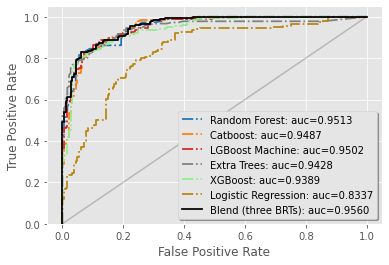

In [66]:
exec(open('ML_sdms_predict.py').read())

In [52]:
# blended (BRTs & RF) feature importance from the validation set
feature_importances[len(feature_importances)-1]
f_score

,LGBoost Machine,Blend (three BRTs),Extra Trees,Catboost,Random Forest,XGBoost,Logistic Regression
F-statistic :,0.877778,0.875346,0.875,0.874317,0.869081,0.861111,0.775401


### Geospatial Predictions of Species Distributions

---

In [53]:
from pyimpute import load_training_vector
from pyimpute import load_targets
from pyimpute import impute

In [54]:
import glob 
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
# grab features, see Appendix section 1 below for feature selection methods
explanatory_rasters = ['bclim11', 'bclim12', 'bclim14', 'bclim15', 'bclim18',
               'bclim2', 'bclim3', 'bclim4', 'bclim6', 'bclim7', 'bclim8','bclim9']
i = 0
for f in explanatory_rasters:
    explanatory_rasters[i] = ('data/train-rasters-2.5m/' + f + '.asc')
    i = (i + 1)
print('\nThere are', len(explanatory_rasters), '.asc features.') # check there are ten 
# grab shapefile containing 100% of the final presence/absence locations
response_data = gpd.GeoDataFrame.from_file('data/geofile-xv-presences/xv.shp') 
response_data.head(4) # check geopandas data 


There are 12 .asc features.


,CLASS,geometry
0,1.0,POINT (-118.42197 35.77997)
1,0.0,POINT (-117.35417 35.27083)
2,1.0,POINT (-118.60656 34.78263)
3,0.0,POINT (-120.18750 37.35417)


In [55]:
print("number of duplicates: ", response_data.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", response_data['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(response_data.crs))
print("{} observations with {} columns".format(*response_data.shape))

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: epsg:4326
1814 observations with 2 columns


In [56]:
# create pyimpute framework
train_xs, train_y = load_training_vector(response_data,
                                         explanatory_rasters,
                                         response_field='CLASS') 
train_xs.shape, train_y.shape # check shape

((1814, 12), (1814,))

In [58]:
# spatial prediction with the 3-model blended classifier
from sklearn import model_selection
import os
session_number = 'exp_id=101, xantusia_after'

target_xs, raster_info = load_targets(explanatory_rasters)
k = 5 
kf = model_selection.KFold(n_splits=k)
accuracy_scores = model_selection.cross_val_score(blender_specific, train_xs, train_y, cv=kf, scoring='accuracy')
print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
blender_specific.fit(train_xs, train_y)
# spatial prediction with impute function, saves tifs to file
os.mkdir('outputs' + session_number)
os.mkdir('outputs' + session_number + '/blender-baseline')
impute(target_xs, blender_specific, raster_info, outdir='outputs' + session_number + '/blender-baseline',
       class_prob=True, certainty=True)

Blend (three BRTs) 5-fold Cross Validation Accuracy: 86.88 (+/- 1.98)


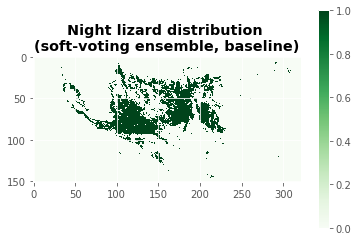

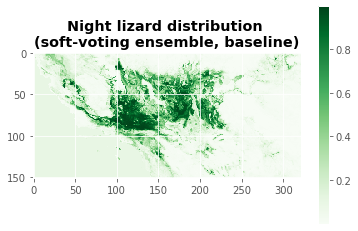

In [111]:
# plot the spatial output of the 3-model blended classifier
from pylab import plt
# define spatial plotter
def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')
blended_curr = rasterio.open('outputs'+ session_number + '/blender-baseline/responses.tif')
plotit(blended_curr.read(1),'Night lizard distribution \n(soft-voting ensemble, baseline)',
        cmap='Greens')
plt.figure()
blended_curr = rasterio.open('outputs' + session_number + '/blender-baseline/probability_1.0.tif') 
plotit(blended_curr.read(1),'Night lizard distribution \n(soft-voting ensemble, baseline)',
       cmap='Greens')
print('')

In [60]:
# Compare the blended ensemble to five tree-based classifiers
CLASS_MAP = {
    'rf': (rf),
    'et': (etrees),
    'xgb': (xgboost),
    'lgbm': (lgbm),
    'cb': (catboost)
    }
for name, (model) in CLASS_MAP.items():
    # Cross val for accuracy scores (as a %) for the entirety of the presence/background database
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    # spatial prediction
    model.fit(train_xs, train_y)
    os.mkdir('outputs' + session_number + '/' + name + '-baseline')
    impute(target_xs, model, raster_info, outdir='outputs' + session_number + '/' + name + '-baseline',
           class_prob=True, certainty=True)

rf 5-fold Cross Validation Accuracy: 86.66 (+/- 2.41)
et 5-fold Cross Validation Accuracy: 86.99 (+/- 1.94)
xgb 5-fold Cross Validation Accuracy: 85.67 (+/- 1.59)
lgbm 5-fold Cross Validation Accuracy: 86.44 (+/- 1.71)
cb 5-fold Cross Validation Accuracy: 86.33 (+/- 1.57)


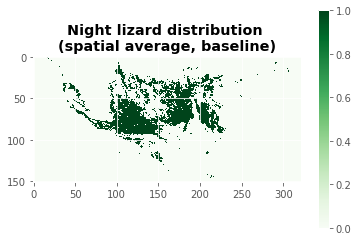

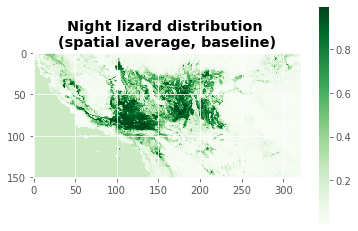

In [114]:
# import rasterio
distr_rf = rasterio.open(
    'outputs' + session_number + '/rf-baseline/probability_1.0.tif').read(1)
distr_et = rasterio.open('outputs' + session_number + '/et-baseline/probability_1.0.tif').read(1)
distr_xgb =  rasterio.open('outputs'+ session_number + '/xgb-baseline/probability_1.0.tif').read(1)
distr_lgbm =  rasterio.open('outputs'+ session_number + '/lgbm-baseline/probability_1.0.tif').read(1)
distr_cb =  rasterio.open('outputs'+ session_number + '/cb-baseline/probability_1.0.tif').read(1)
spatial_blend = (distr_rf + distr_et + distr_xgb + distr_lgbm + distr_cb)/5  

plotit(spatial_blend > 0.5, 'Night lizard distribution \n(spatial average, baseline)',
       cmap = 'Greens')
plt.figure()
plotit(spatial_blend, 'Night lizard distribution \n(spatial average, baseline)',
       cmap = 'Greens')
print('')

### Predicting Suitability Under Climate Change Scenarios
---

In [87]:
tag = 'ssp370_2081-2100'
# extrapolate model to all eight GCMs for the above scenario
exec(open('future_projection.py').read())

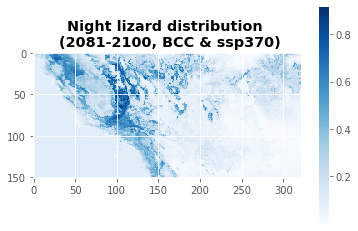

In [122]:
future = rasterio.open('data/CMIP6/ssp370_2081-2100/BCC/probability_1.0.tif').read(1)
plotit(future, 'Night lizard distribution \n (2081-2100, BCC & ssp370)')

### Appendix 1: Removing Correlated Features
---

Recursively selects de-correlated features for modeling below a Spearman's threshold, using the rank of feature importance scores.

---


In [75]:
exec(open('recursive-ranker.py').read())

In [76]:
# load csv files for recursion function
covariance = pd.read_csv('data/collinearity/xv-baseline.csv')
feature_importance = pd.read_csv('maxent/maxent_19_variables_xv/maxent-jacknife.csv')
feature_importance.rename(index={0: 'importance'}, inplace = True)
feature_importance.sort_values(by='importance', axis=1, ascending=False)

,bclim6,bclim8,bclim11,bclim18,bclim1,bclim14,bclim9,bclim17,bclim10,bclim5,bclim15,bclim4,bclim7,bclim12,bclim3,bclim19,bclim13,bclim16,bclim2
importance,0.591,0.5659,0.5228,0.3416,0.3216,0.3191,0.2835,0.2803,0.2458,0.1822,0.1669,0.0937,0.081,0.072,0.0457,0.0456,0.0352,0.0334,0.0258


In [77]:
recursive_ranker(covariance, feature_importance, 0.85, pd.read_csv('data/collinearity/raw_data.csv'))

Comparing bclim16 or bclim19  | Dropping bclim16
Comparing bclim13 or bclim19  | Dropping bclim13
Comparing bclim1 or bclim10  | Dropping bclim10
Comparing bclim14 or bclim17  | Dropping bclim17
Comparing bclim12 or bclim19  | Dropping bclim19
Comparing bclim1 or bclim5  | Dropping bclim5
Comparing bclim1 or bclim11  | Dropping bclim1

final set of variables:  ['bclim11', 'bclim12', 'bclim14', 'bclim15', 'bclim18', 'bclim2', 'bclim3', 'bclim4', 'bclim6', 'bclim7', 'bclim8', 'bclim9']

Covariance matrix (r <  0.85 ):

         bclim11   bclim12   bclim14   bclim15   bclim18    bclim2    bclim3  \
bclim11      1.0  0.360369  0.601673  0.153659  0.324422  0.154140  0.085145   
bclim12      0.0  1.000000  0.185364  0.517731  0.101761  0.309390  0.352861   
bclim14      0.0  0.000000  1.000000  0.632534  0.831020  0.360974  0.494897   
bclim15      0.0  0.000000  0.000000  1.000000  0.714014  0.021618  0.622199   
bclim18      0.0  0.000000  0.000000  0.000000  1.000000  0.413650  0.570669 

### Appendix 2 : Feature Descriptions
---

**Description for features is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|BioClim11| Mean Temp of Coldest Quarter | $^o$C
|BioClim12| Annual Precipitation | mm
|BioClim14| Precip Driest Month| mm
|BioClim15| Precip Seasonality | (coefficient of variation)
|BioClim18| Precip Warmest Quarter | mm
|BioClim2| Diurnal Range | (Mean of monthly (max temp - min temp))
|BioClim3| Isothermality | (BIO2/BIO7) (×100)
|BioClim4| Temperature Seasonality | (standard deviation(C) ×100)|
|BioClim6| Min Temp Coldest Month| $^o$C
|BioClim7| Temp Annual Range| $^o$C
|BioClim8| Mean Temp Wettest Quareter | $^o$C
|BioClim9| Mean Temp Driest Quareter | $^o$C

**Description for the target variable is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|Pa| Binary class | 1 (presence) & 0 (background)

### Appendix 3 : MLFlow backend server, see model parameters
---

In [65]:
from pycaret.classification import get_logs
get_logs(experiment_name = 'xantusia_after')

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.TT,metrics.MCC,metrics.AUC,metrics.F1,...,tags.USI,tags.Run ID,tags.mlflow.log-model.history,tags.URI,tags.mlflow.runName,tags.Run Time,tags.Source,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type
0,65b98db5713b46d9a719d2b783e3cb6d,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-11 20:32:29.386000+00:00,2020-11-11 20:32:29.611000+00:00,0.020,0.326700,0.000000,0.587800,...,1a5a,65b98db5713b46d9a719d2b783e3cb6d,"[{""run_id"": ""65b98db5713b46d9a719d2b783e3cb6d""...",d8852d07,SVM - Linear Kernel,0.41,compare_models,danielfurman,/opt/anaconda3/lib/python3.7/site-packages/ipy...,LOCAL
1,679984f2a48c4d06acf93750bbe88578,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-11 20:32:28.810000+00:00,2020-11-11 20:32:29.126000+00:00,0.011,0.561900,0.851200,0.776200,...,1a5a,679984f2a48c4d06acf93750bbe88578,"[{""run_id"": ""679984f2a48c4d06acf93750bbe88578""...",d8852d07,Naive Bayes,0.32,compare_models,danielfurman,/opt/anaconda3/lib/python3.7/site-packages/ipy...,LOCAL
2,0aabcb259ea944f9b1edfd39df3a1b1b,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-11 20:32:28.209000+00:00,2020-11-11 20:32:28.552000+00:00,0.020,0.573100,0.847600,0.780800,...,1a5a,0aabcb259ea944f9b1edfd39df3a1b1b,"[{""run_id"": ""0aabcb259ea944f9b1edfd39df3a1b1b""...",d8852d07,Linear Discriminant Analysis,0.57,compare_models,danielfurman,/opt/anaconda3/lib/python3.7/site-packages/ipy...,LOCAL
3,45b60425b2de497c9a556865df6943e4,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-11 20:32:27.645000+00:00,2020-11-11 20:32:27.928000+00:00,0.190,0.568800,0.847400,0.781600,...,1a5a,45b60425b2de497c9a556865df6943e4,"[{""run_id"": ""45b60425b2de497c9a556865df6943e4""...",d8852d07,Logistic Regression,2.13,compare_models,danielfurman,/opt/anaconda3/lib/python3.7/site-packages/ipy...,LOCAL
4,e80558c68c3e4026af2b300ea73fcdfe,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-11 20:32:27.164000+00:00,2020-11-11 20:32:27.402000+00:00,0.015,0.575200,0.000000,0.781800,...,1a5a,e80558c68c3e4026af2b300ea73fcdfe,"[{""run_id"": ""e80558c68c3e4026af2b300ea73fcdfe""...",d8852d07,Ridge Classifier,0.36,compare_models,danielfurman,/opt/anaconda3/lib/python3.7/site-packages/ipy...,LOCAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,c9f577b48ad845bda73472b3546cc566,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:44:57.582000+00:00,2020-11-08 02:44:58.067000+00:00,0.470,0.674796,0.920981,0.835128,...,d6c2,c9f577b48ad845bda73472b3546cc566,"[{""run_id"": ""c9f577b48ad845bda73472b3546cc566""...",983bb4c0,Random Forest Classifier,3.85,create_model,danielfurman,/opt/anaconda3/lib/python3.7/site-packages/ipy...,LOCAL
296,a7f55ac54aa34224b6dd0cc0d19c5021,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:44:53.179000+00:00,2020-11-08 02:44:53.426000+00:00,2.730,0.676497,0.919227,0.836141,...,d6c2,a7f55ac54aa34224b6dd0cc0d19c5021,"[{""run_id"": ""a7f55ac54aa34224b6dd0cc0d19c5021""...",e47ad7f3,CatBoost Classifier,21.84,create_model,danielfurman,/opt/anaconda3/lib/python3.7/site-packages/ipy...,LOCAL
297,a09a20534b5449f1a630dab9fbdfeca5,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:44:30.738000+00:00,2020-11-08 02:44:31.053000+00:00,0.210,0.672957,0.911961,0.834109,...,d6c2,a09a20534b5449f1a630dab9fbdfeca5,"[{""run_id"": ""a09a20534b5449f1a630dab9fbdfeca5""...",16fcb9d9,Extreme Gradient Boosting,3.14,create_model,danielfurman,/opt/anaconda3/lib/python3.7/site-packages/ipy...,LOCAL
298,d7509bc5c0ea4cbcba6caad014d22cf4,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:44:26.793000+00:00,2020-11-08 02:44:27.323000+00:00,0.480,0.694989,0.923170,0.846110,...,d6c2,d7509bc5c0ea4cbcba6caad014d22cf4,"[{""run_id"": ""d7509bc5c0ea4cbcba6caad014d22cf4""...",f176e578,Extra Trees Classifier,6.95